In [1]:
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

from albumentations import BboxParams
from collections import Counter
from PIL import Image

In [2]:
def load_images_and_labels(image_directory, coordinates_directory, image_size=(128, 128)):
    # Load and sort filenames
    image_filenames = sorted([f for f in os.listdir(image_directory) if f.endswith('.jpg')])
    annotation_filenames = sorted([f for f in os.listdir(coordinates_directory) if f.endswith('.txt')])

    # Ensure matching files
    if len(image_filenames) != len(annotation_filenames):
        raise ValueError("Mismatch in number of images and annotations!")

    for img_file, coord_file in zip(image_filenames, annotation_filenames):
        if os.path.splitext(img_file)[0] != os.path.splitext(coord_file)[0]:
            raise ValueError(f"Mismatched file names: {img_file} and {coord_file}")

    # Load images and annotations
    image_data = []
    annotations = []

    for img_file, coord_file in zip(image_filenames, annotation_filenames):
        # Load image
        img_path = os.path.join(image_directory, img_file)
        img = Image.open(img_path).convert("L")  # Convert to grayscale
        img_resized = img.resize(image_size)  # Resize for consistency
        image_data.append(np.array(img_resized))

        # Load YOLO annotations
        coord_path = os.path.join(coordinates_directory, coord_file)
        with open(coord_path, 'r') as file:
            data = file.readlines()
            coords = []
            classes = []
            for line in data:
                parts = list(map(float, line.strip().split()))
                class_id = int(parts[0])
                x_center, y_center, width, height = parts[1:]

                # Convert normalized YOLO coordinates to pixel values
                x_pixel = x_center * image_size[0]
                y_pixel = y_center * image_size[1]
                box_width = width * image_size[0]
                box_height = height * image_size[1]

                # Append coordinates and classes
                coords.append([x_pixel, y_pixel, box_width, box_height])
                classes.append(class_id)
            annotations.append({'coordinates': coords, 'classes': classes})

    # Normalize image data and expand dimensions
    image_data = np.array(image_data) / 255.0
    image_data = np.expand_dims(image_data, axis=-1)  # Shape: (num_samples, 128, 128, 1)

    return image_data, annotations


def explore_dataset(image_data, annotations_data, print_label_counts=True, plot_last_image=True):
    """
    Prints number of images and annotations and plot the first ten images
    Optionally prints label counts and plots the last image
    """
    # Verify dataset sizes
    print(f"Number of Images: {len(image_data)}")
    print(f"Number of Annotations: {len(annotations_data)}")

    # Visualize the first 10 images with annotations
    for i in range(10):
        img = image_data[i].squeeze()  # Remove channel dimension if present
        ann = annotations_data[i]
        coords = np.array(ann['coordinates']).reshape(-1, 4)  # Reshape to (num_boxes, 4)
        classes = ann['classes']

        plt.figure()
        plt.imshow(img, cmap='gray')

        for j, (x, y, w, h) in enumerate(coords):
            # Draw bounding boxes
            rect = plt.Rectangle(
                (x - w / 2, y - h / 2), w, h,
                linewidth=1, edgecolor='r', facecolor='none'
            )
            plt.gca().add_patch(rect)

            # Annotate the class
            plt.text(
                x, y - h / 2, f"Class {classes[j]}",
                color='blue', fontsize=8
            )

        plt.grid(False)
        plt.show()


    if print_label_counts:
        # Extract all classes from annotations
        train_labels = [cls for annotation in annotations_data for cls in annotation['classes']]

        # Count occurrences of each class
        label_counts = Counter(train_labels)

        # Print the counts for each class
        print("Number of labels per class:")
        for label, count in sorted(label_counts.items()):
            print(f"Class {label}: {count}")

    if plot_last_image:
        # Visualize the last image with its annotations
        print(f"Last image annotations: {annotations_data[-1]}")
        plt.figure()
        plt.imshow(image_data[-1].squeeze(), cmap='gray')  # Use .squeeze() to remove the channel dimension
        plt.colorbar()
        plt.grid(False)
        plt.show()


def data_augmentation(image_data, annotations_data, output_size=(128, 128)):
    # Define augmentation pipeline
    transform = A.Compose(
        [
            A.Rotate(limit=20, p=0.5),  # Rotate images
            A.HorizontalFlip(p=0.5),  # Flip horizontally
            A.RandomBrightnessContrast(p=0.5),  # Adjust brightness/contrast
            A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20, p=0.5),  # Shift, scale, rotate
        ],
        bbox_params=BboxParams(format="yolo", label_fields=["class_labels"])  # Maintain YOLO format
    )

    # Augment images and adjust bounding boxes
    augmented_images = []
    augmented_annotations = []

    for img, annotation in zip(image_data, annotations_data):
        h, w = output_size  # Resized dimensions
        bboxes = []
        class_labels = []

        # Normalize bounding boxes for Albumentations
        for cls, bbox in zip(annotation['classes'], np.array(annotation['coordinates']).reshape(-1, 4)):
            x_center, y_center, box_width, box_height = bbox
            # Normalize coordinates
            x_center /= w
            y_center /= h
            box_width /= w
            box_height /= h

            # Filter out invalid bounding boxes
            if 0 < box_width <= 1 and 0 < box_height <= 1 and 0 < x_center <= 1 and 0 < y_center <= 1:
                bboxes.append([x_center, y_center, box_width, box_height])
                class_labels.append(cls)

        # Skip augmentation if no valid bounding boxes
        if not bboxes:
            continue

        # Augment each image multiple times (e.g., 5 augmentations per image)
        for _ in range(5):  # Generate 5 augmented samples per original image
            augmented = transform(image=(img.squeeze() * 255).astype(np.uint8), bboxes=bboxes,
                                  class_labels=class_labels)

            # Filter augmented bounding boxes
            valid_bboxes = []
            valid_classes = []
            for bbox, cls in zip(augmented["bboxes"], augmented["class_labels"]):
                x_center, y_center, box_width, box_height = bbox
                # Validate again after augmentation
                if 0 < box_width <= 1 and 0 < box_height <= 1 and 0 < x_center <= 1 and 0 < y_center <= 1:
                    valid_bboxes.append([x_center, y_center, box_width, box_height])
                    valid_classes.append(cls)

            # Skip if no valid bounding boxes remain
            if not valid_bboxes:
                continue

            # Add to augmented dataset
            augmented_images.append(augmented["image"])
            augmented_annotations.append({"bboxes": valid_bboxes, "classes": valid_classes})

    # Convert augmented images to NumPy array
    augmented_images = np.array(augmented_images)

    return augmented_images, augmented_annotations


def explore_augmented_data(augmented_images, augmented_annotations, num_images=3):
    """
    Plot augmented images with bounding boxes
    Number of images to visualize is defined by num_images
    """
    # Visualize augmented ROIs and bounding boxes
    for i in range(num_images):  # Display 3 examples
        img = augmented_images[i]
        bboxes = augmented_annotations[i]["bboxes"]
        classes = augmented_annotations[i]["classes"]

        h, w = img.shape[:2]
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # Convert grayscale to BGR for visualization

        for bbox, cls in zip(bboxes, classes):
            x_center, y_center, box_width, box_height = bbox
            x_center *= w
            y_center *= h
            box_width *= w
            box_height *= h
            x_min = int(x_center - box_width / 2)
            y_min = int(y_center - box_height / 2)
            x_max = int(x_center + box_width / 2)
            y_max = int(y_center + box_height / 2)

            # Draw bounding box
            cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
            cv2.putText(img, f"Class {cls}", (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

        # Plot image
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()


In [3]:
data_folder = "Training Set/"
images_folder = os.path.join(data_folder, "Training Images")
coordinates_folder = os.path.join(data_folder, "Training Coordinates")

training_image, training_labels = load_images_and_labels(images_folder, coordinates_folder)


Number of Images: 115
Number of Annotations: 115


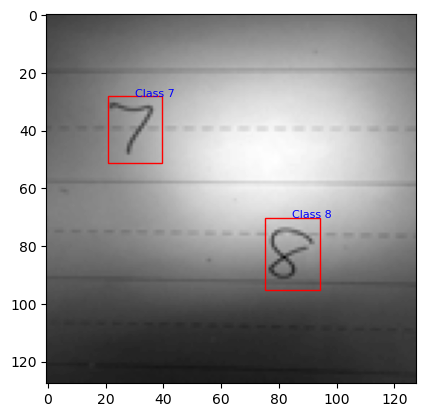

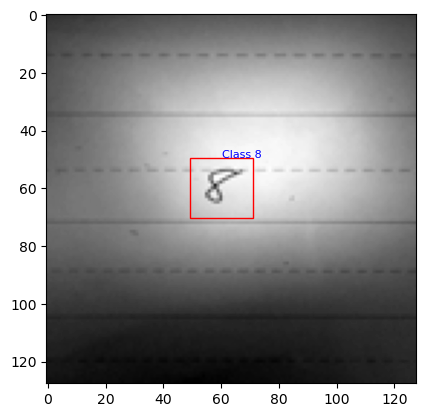

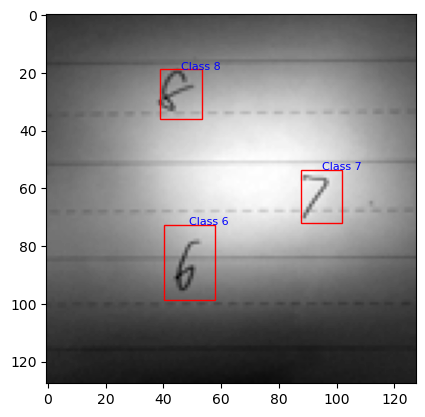

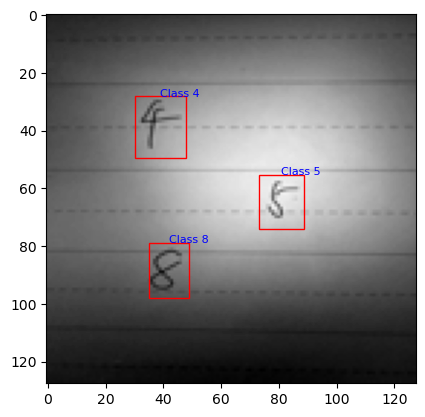

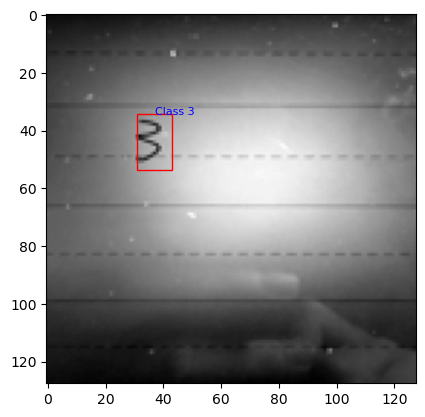

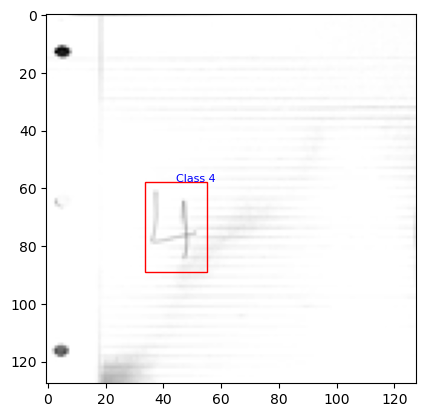

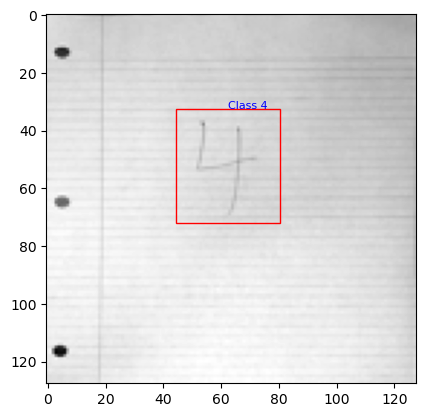

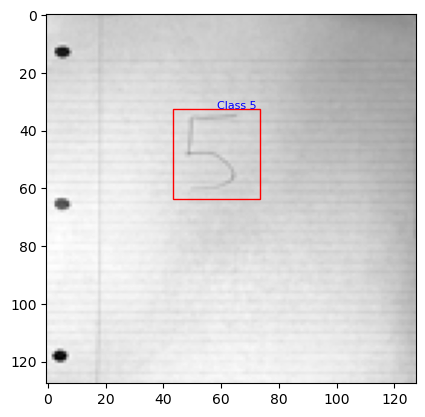

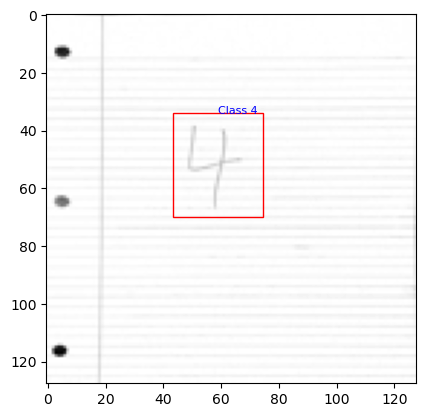

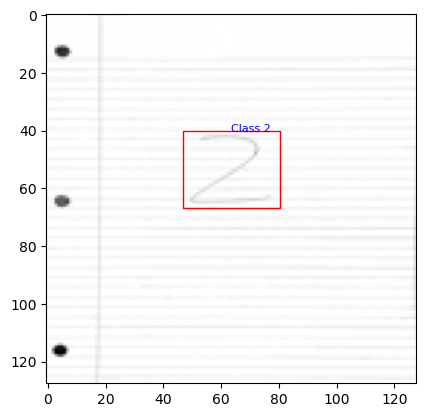

Number of labels per class:
Class 0: 15
Class 1: 12
Class 2: 23
Class 3: 20
Class 4: 16
Class 5: 17
Class 6: 20
Class 7: 15
Class 8: 16
Class 9: 18
Last image annotations: {'coordinates': [[55.260416, 58.544512, 20.193408, 21.984768]], 'classes': [8]}


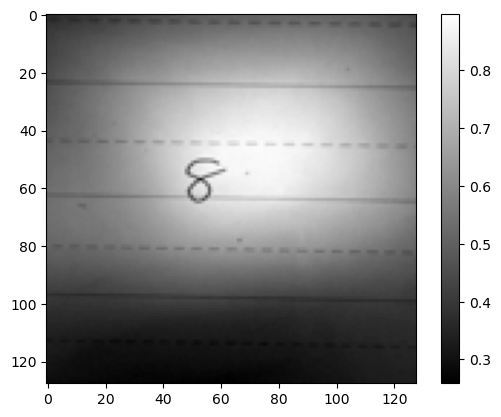

In [4]:
explore_dataset(training_image, training_labels)


In [5]:
augmented_images, augmented_annotations = data_augmentation(training_image, training_labels)


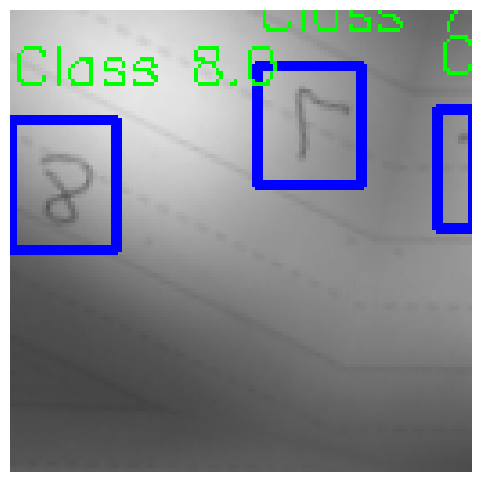

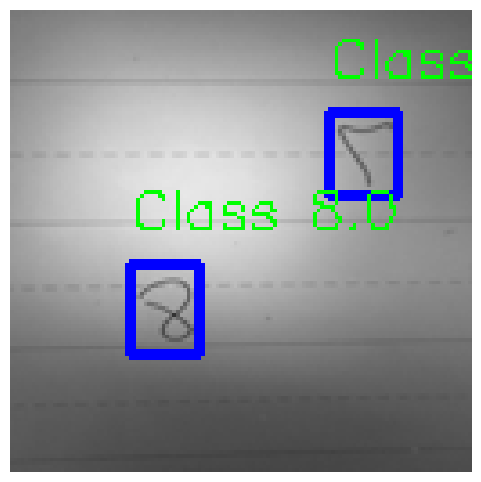

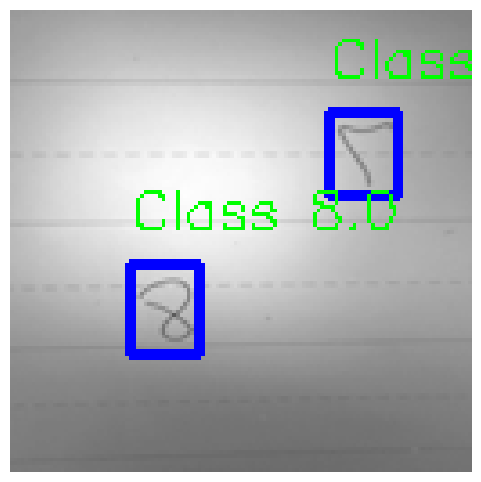

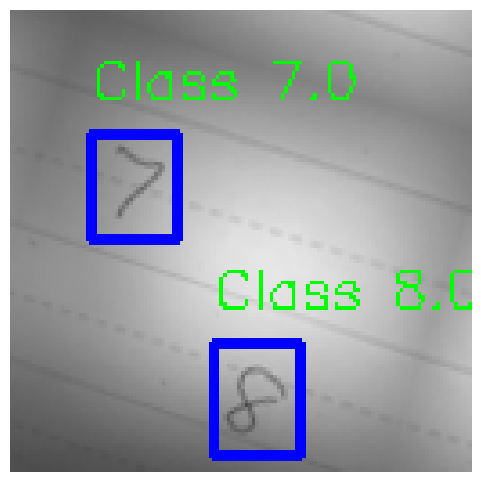

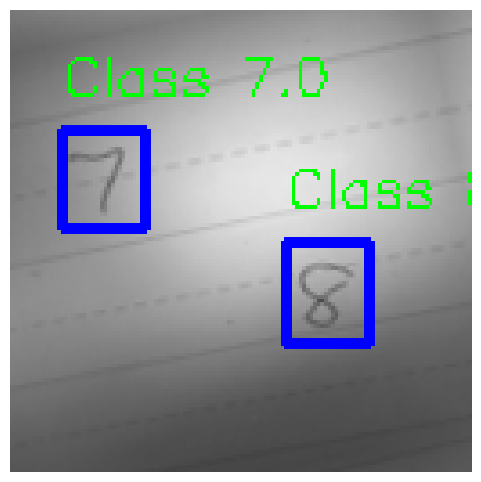

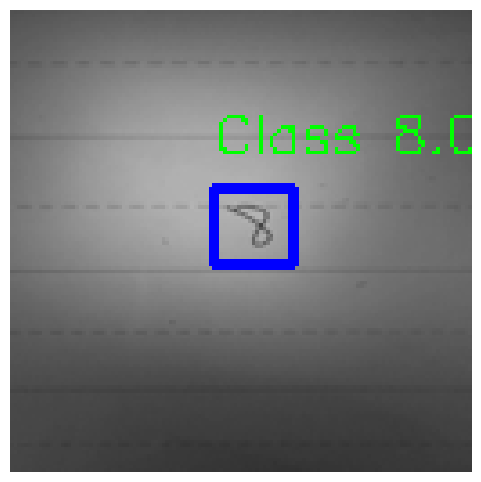

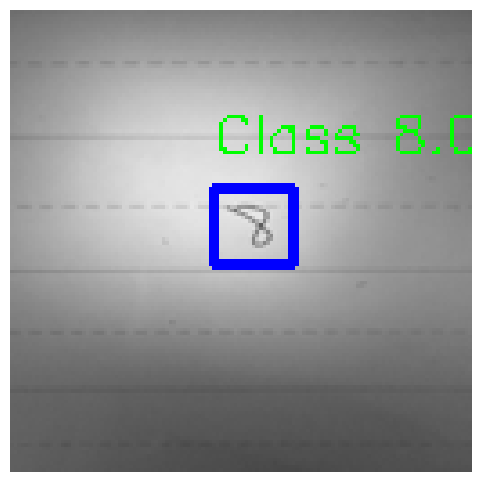

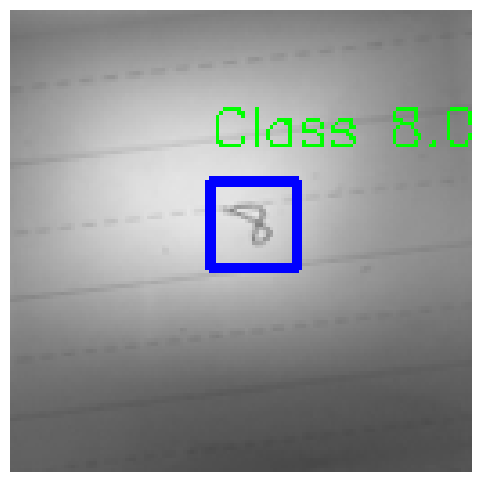

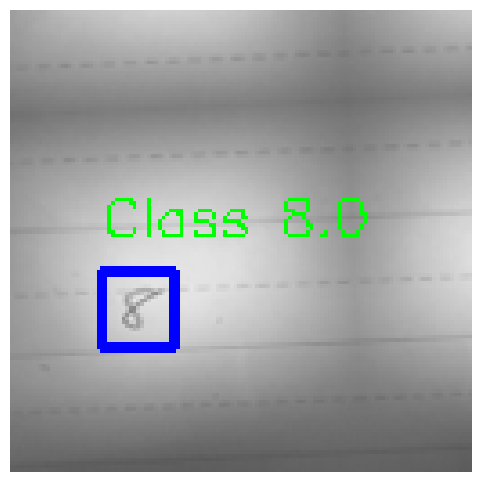

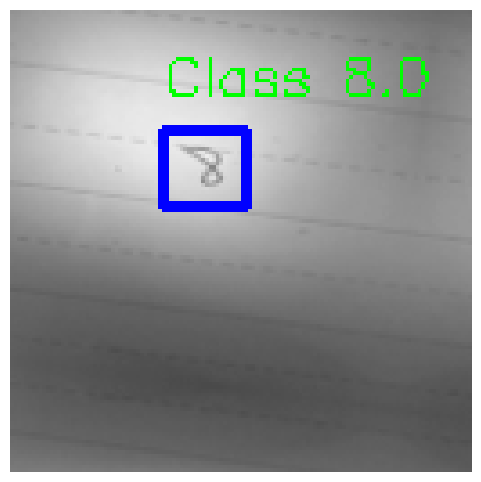

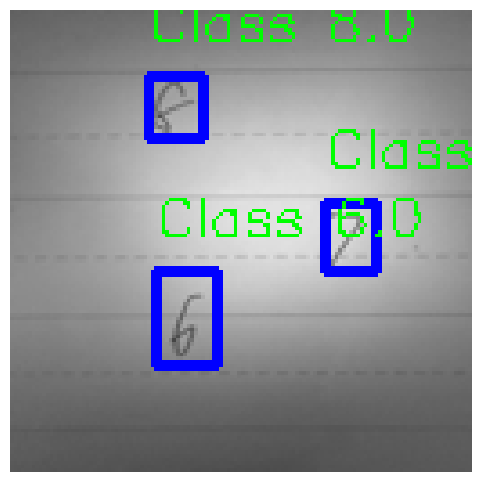

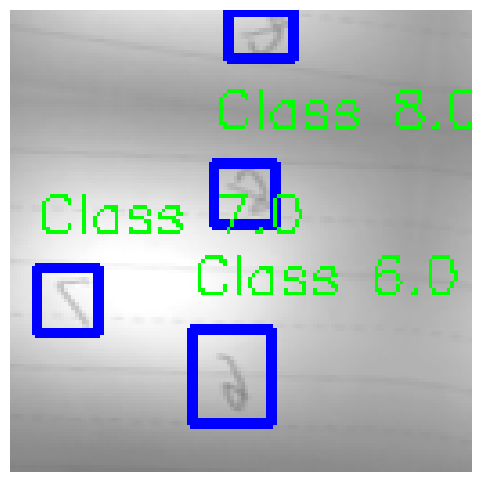

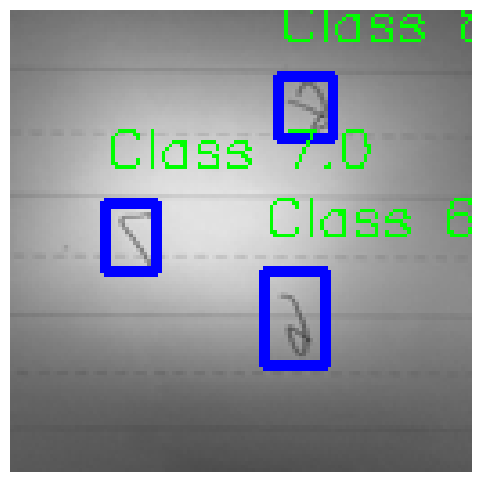

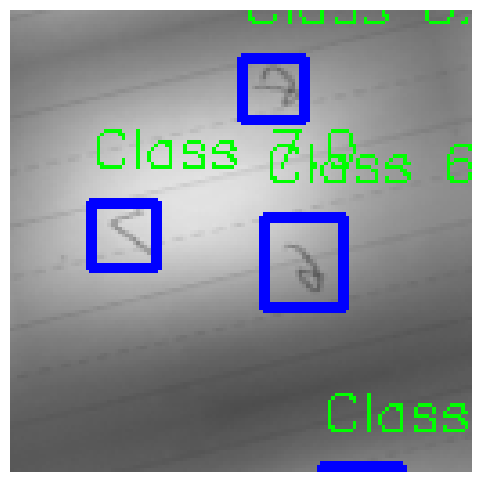

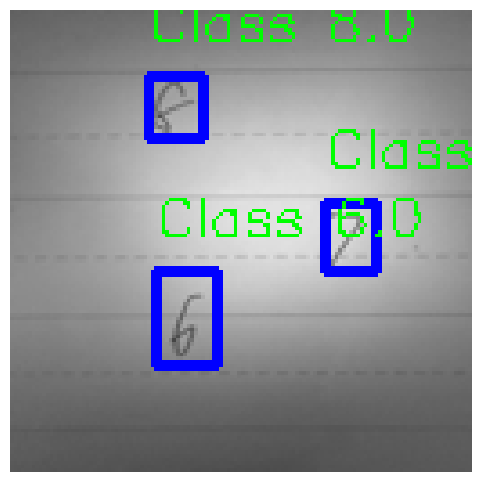

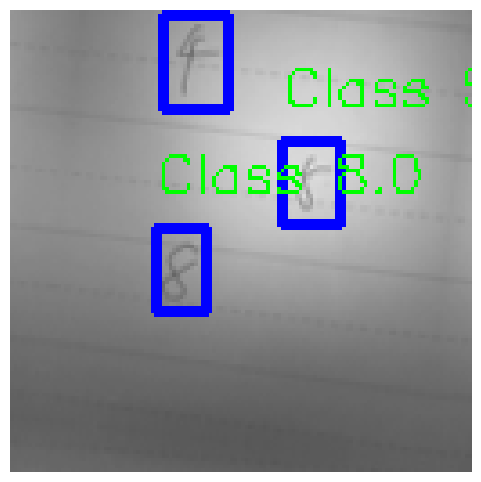

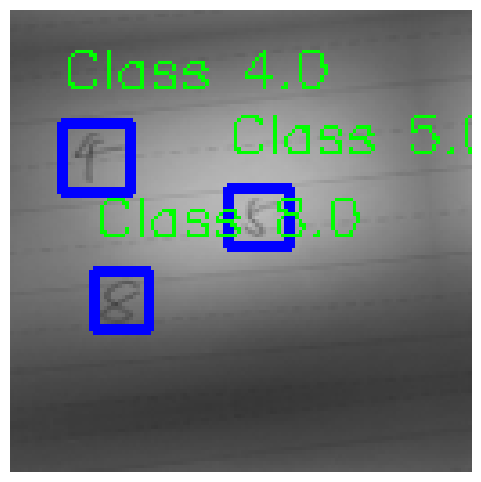

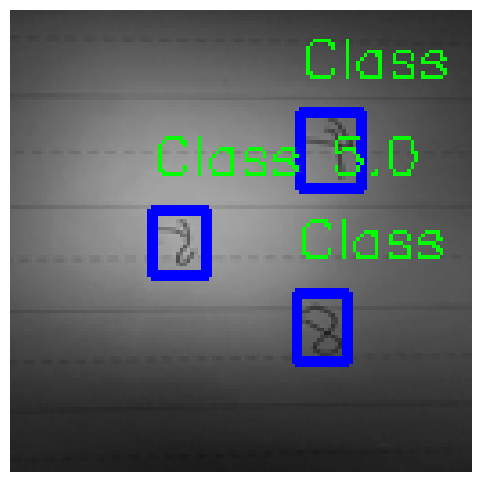

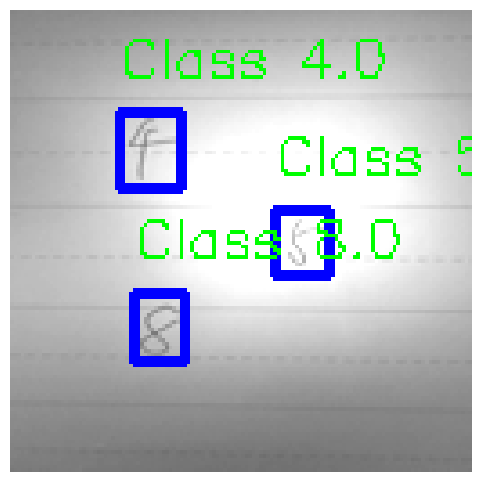

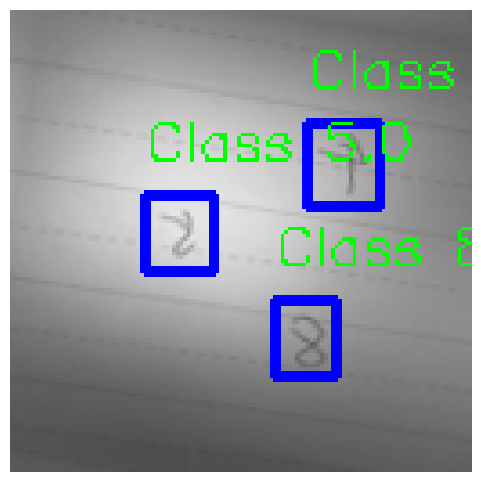

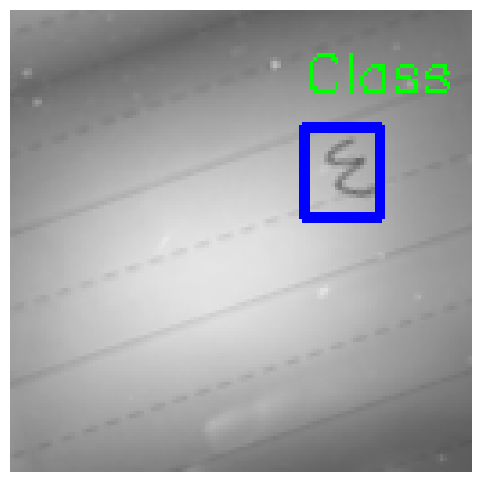

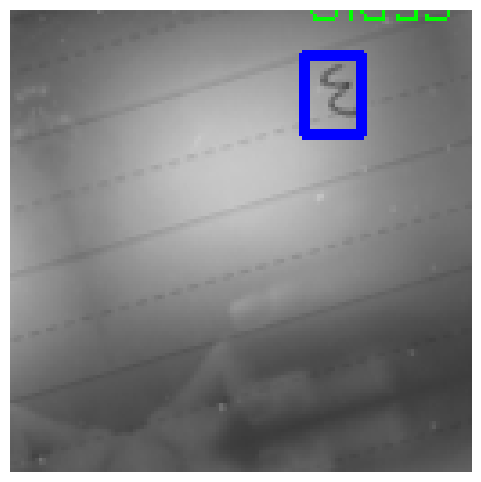

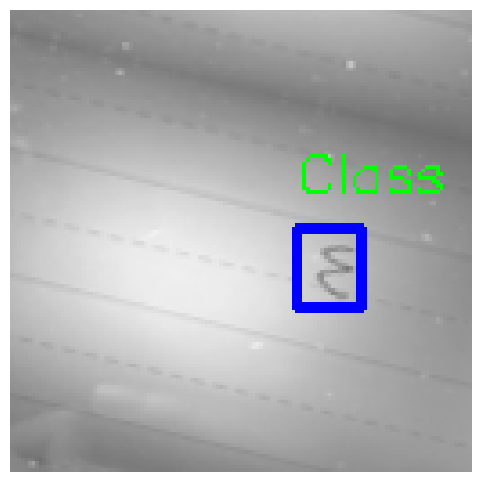

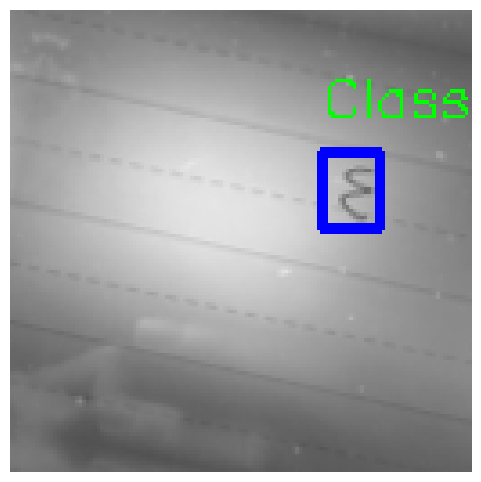

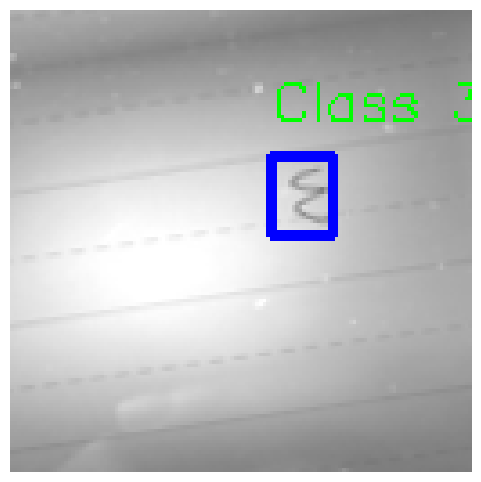

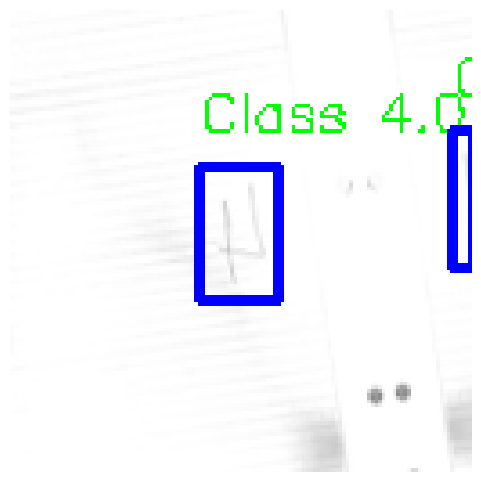

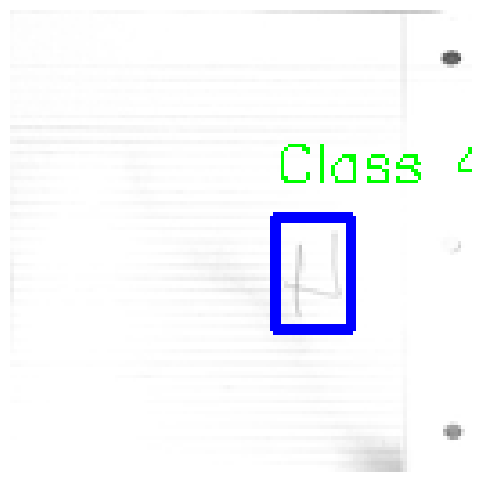

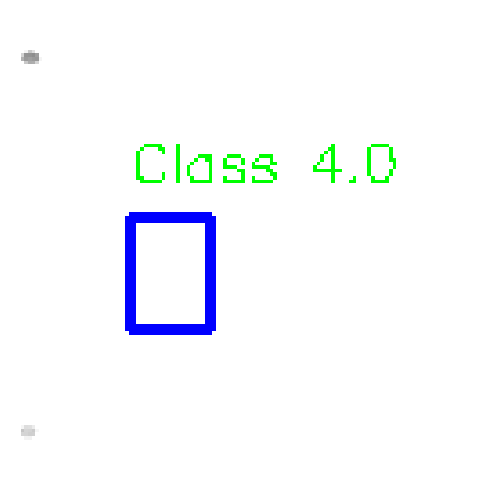

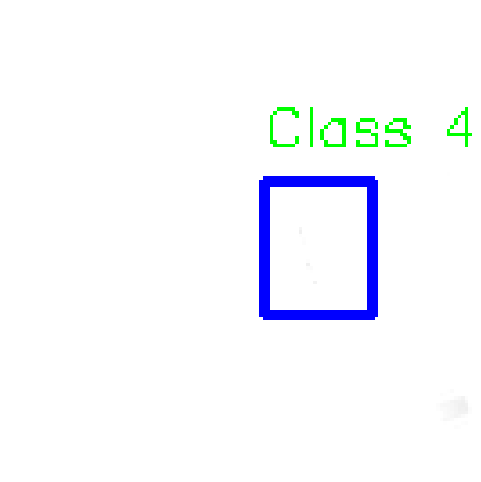

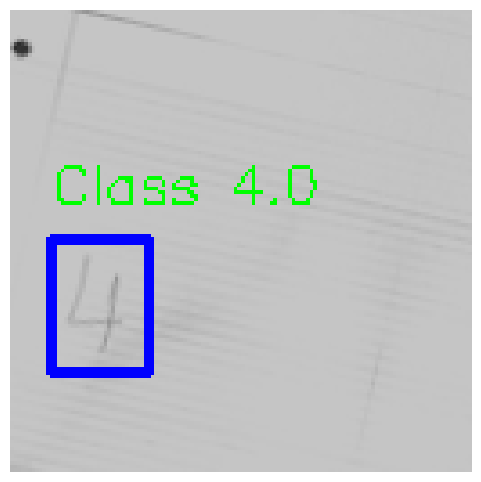

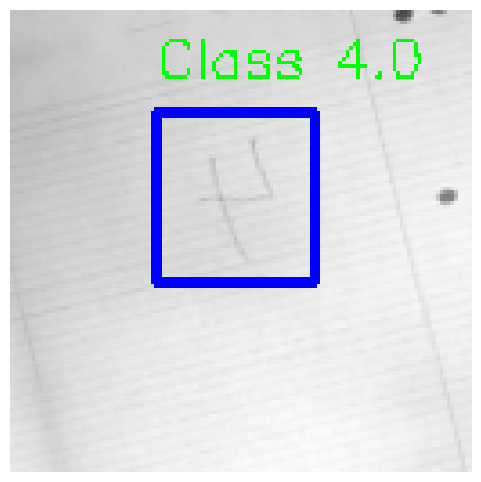

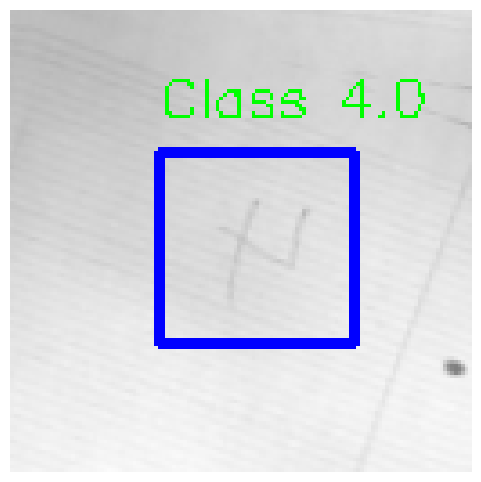

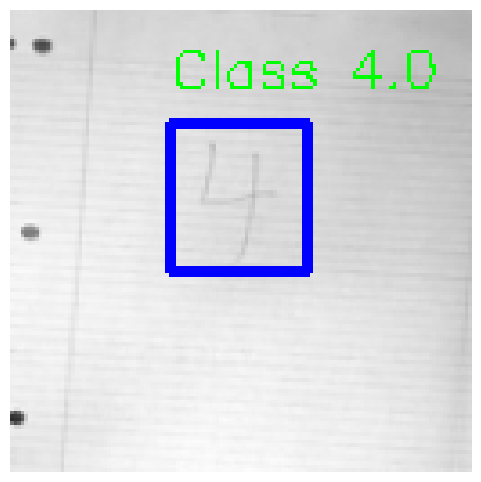

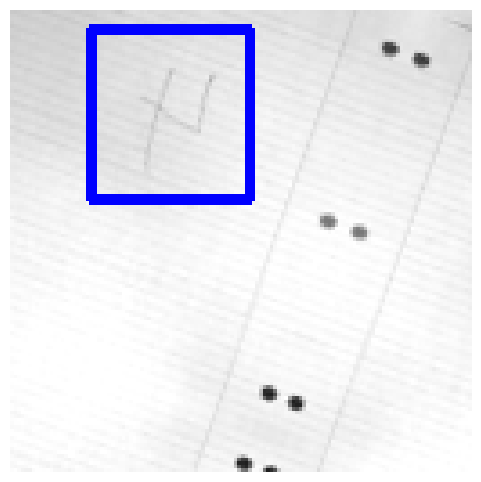

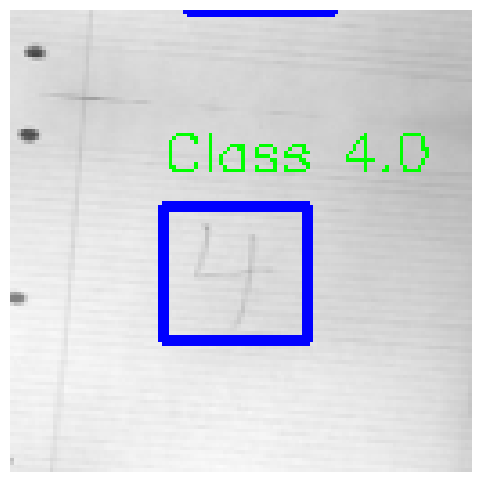

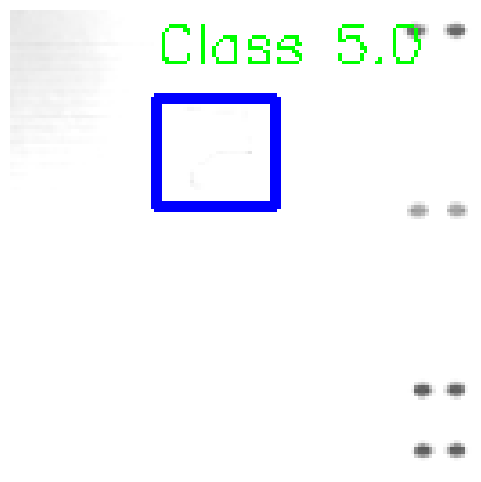

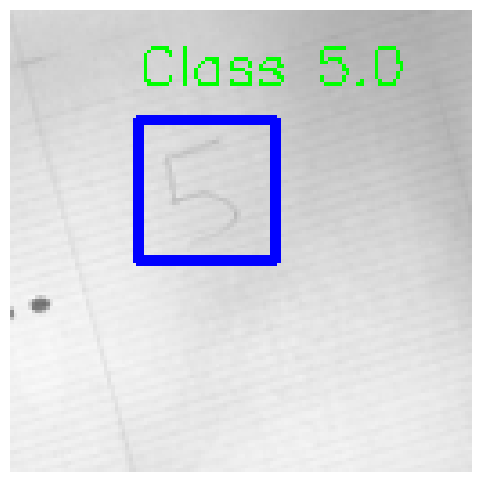

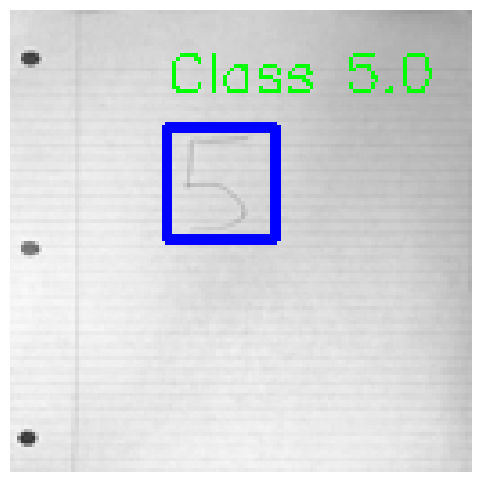

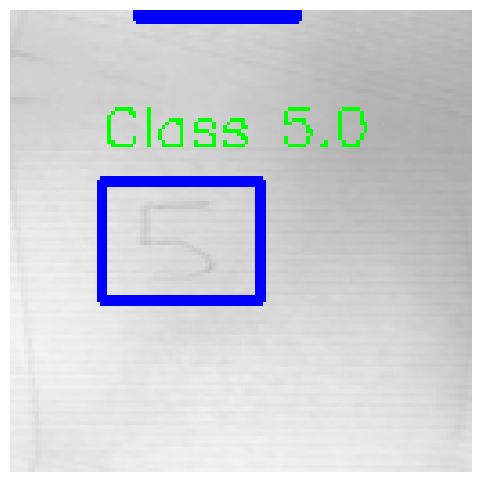

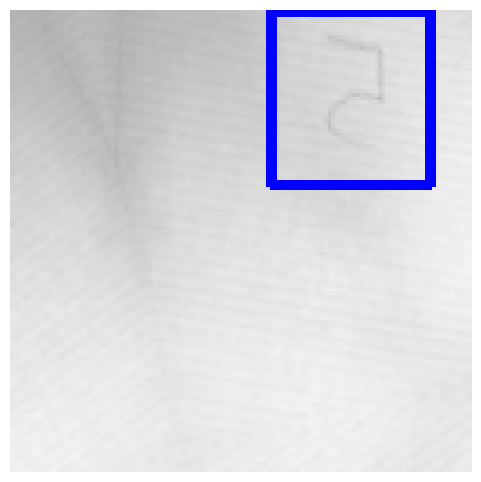

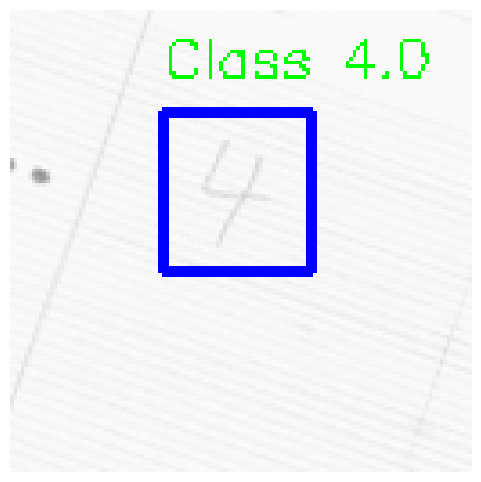

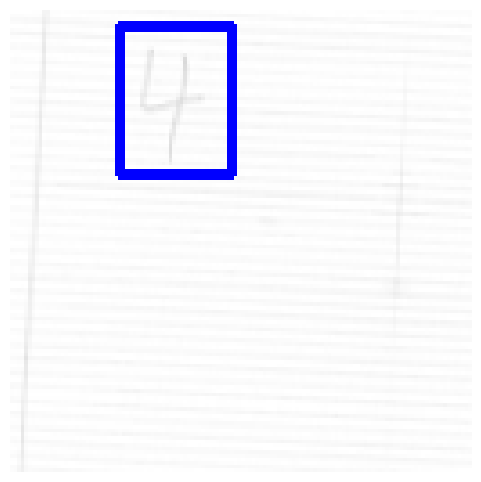

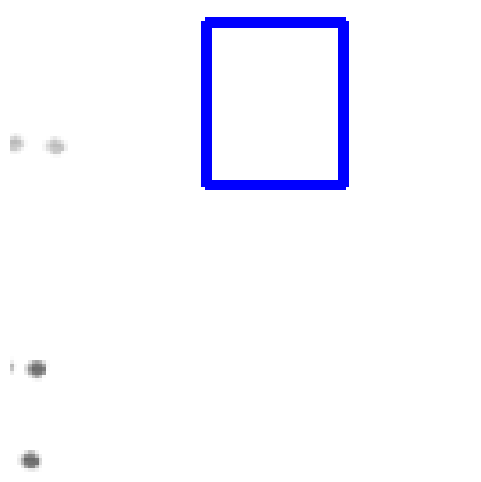

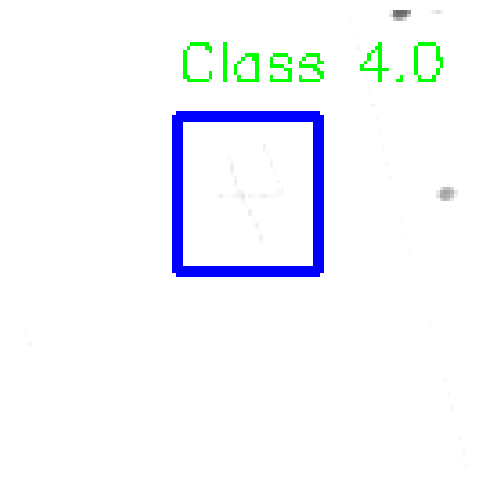

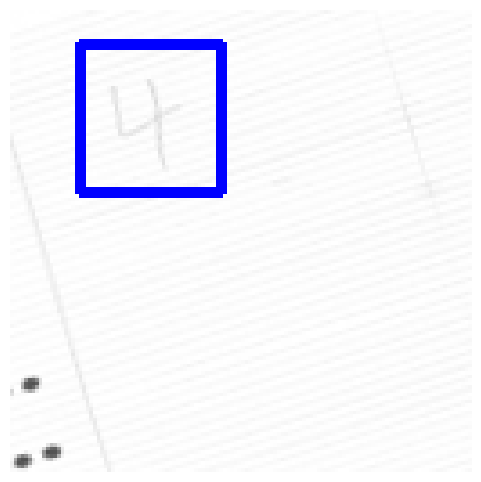

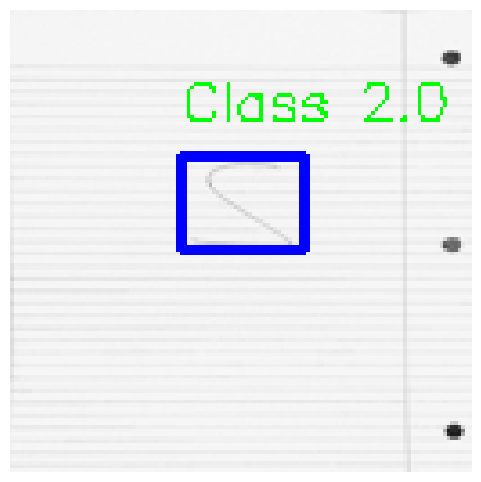

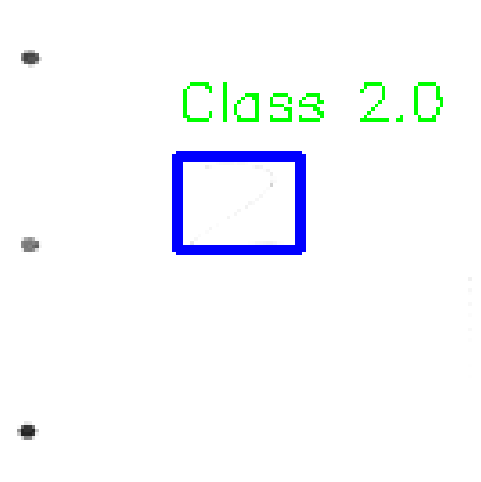

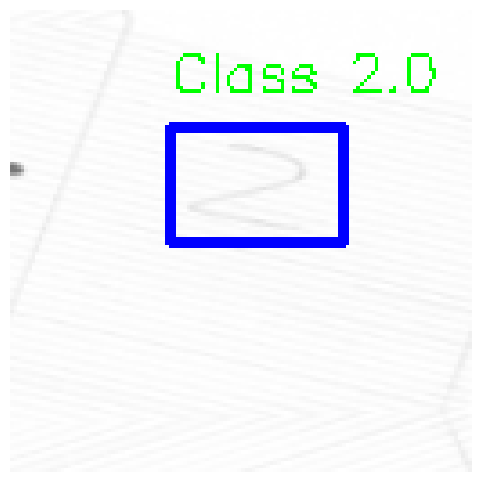

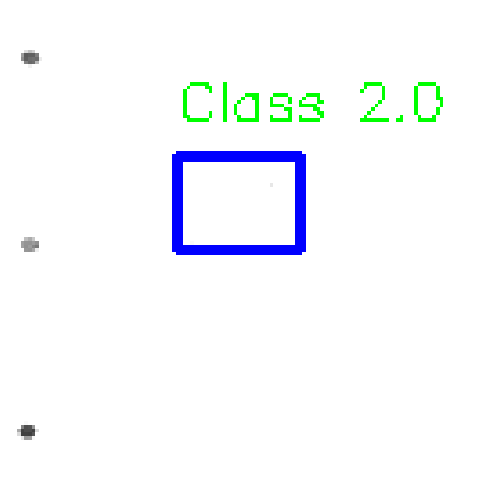

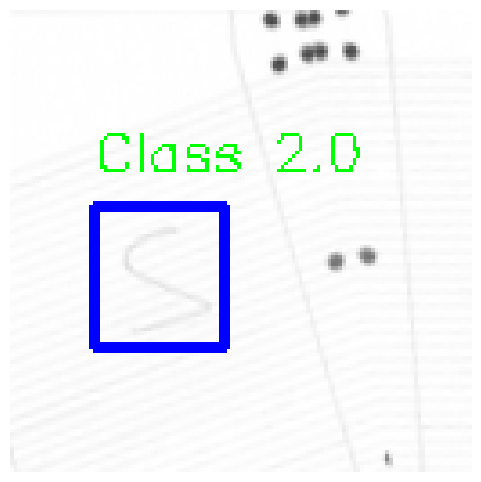

In [6]:
explore_augmented_data(augmented_images, augmented_annotations, 50)
